# fastai baseline

> Classifiying Corn images with fast.ai framework

## Contents

1. Imports and read data
2. Creating a dataloader with fastai
3. Training model with convnext
4. Submitting Predictions




In [1]:
! pip install -Uqq timm

## Imports and Read data

In [2]:
import albumentations as A
import timm
from pathlib import Path
from fastai.vision.all import *
from fastai.vision.all import vision_learner, get_image_files

In [3]:
path = Path("/kaggle/input/kaggle-pog-series-s01e03/corn/")
path.ls()

(#5) [Path('/kaggle/input/kaggle-pog-series-s01e03/corn/sample_submission.csv'),Path('/kaggle/input/kaggle-pog-series-s01e03/corn/train.csv'),Path('/kaggle/input/kaggle-pog-series-s01e03/corn/test.csv'),Path('/kaggle/input/kaggle-pog-series-s01e03/corn/test'),Path('/kaggle/input/kaggle-pog-series-s01e03/corn/train')]

In [4]:
train_df = pd.read_csv(path/"train.csv")
test_df = pd.read_csv(path/"test.csv")
train_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [5]:
sub_df = pd.read_csv(path/"sample_submission.csv")
sub_df.head()

,seed_id,label
0,8632,broken
1,11394,broken
2,17362,pure
3,9987,discolored
4,17226,silkcut


In [6]:
files = get_image_files(path / "train")

def f(o):
    return PILImage.create(o).size


sizes = parallel(f, files, n_workers=4)
sizes

(#14322) [(136, 148),(136, 176),(144, 144),(136, 136),(132, 140),(116, 112),(136, 140),(156, 144),(156, 160),(148, 156)...]

In [7]:
set(sizes)

{(84, 92),
 (84, 96),
 (88, 116),
 (92, 108),
 (92, 112),
 (92, 144),
 (96, 104),
 (96, 108),
 (96, 112),
 (96, 132),
 (96, 133),
 (98, 148),
 (100, 100),
 (100, 108),
 (100, 112),
 (100, 120),
 (100, 128),
 (100, 132),
 (100, 136),
 (100, 140),
 (100, 144),
 (100, 148),
 (100, 176),
 (100, 188),
 (100, 200),
 (102, 128),
 (103, 132),
 (104, 96),
 (104, 104),
 (104, 108),
 (104, 112),
 (104, 116),
 (104, 120),
 (104, 124),
 (104, 128),
 (104, 132),
 (104, 136),
 (104, 140),
 (104, 144),
 (104, 148),
 (104, 156),
 (104, 164),
 (104, 172),
 (104, 176),
 (104, 180),
 (104, 184),
 (107, 124),
 (107, 132),
 (107, 148),
 (108, 100),
 (108, 104),
 (108, 108),
 (108, 112),
 (108, 116),
 (108, 120),
 (108, 124),
 (108, 128),
 (108, 132),
 (108, 136),
 (108, 140),
 (108, 144),
 (108, 156),
 (108, 160),
 (108, 164),
 (108, 168),
 (108, 180),
 (111, 108),
 (111, 128),
 (111, 132),
 (112, 88),
 (112, 100),
 (112, 104),
 (112, 108),
 (112, 112),
 (112, 116),
 (112, 120),
 (112, 124),
 (112, 128),
 (

**Note: The images seems to be of different sizes, which is going to make the problem challenging**

In [8]:
train_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


## Augmenting Images with albumentations

In [9]:
def get_train_aug(): 
    return A.Compose([
    A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
    A.CoarseDropout(p=0.5),
    A.RandomBrightnessContrast(p=1),    
    A.RandomGamma(p=1),    
    A.CLAHE(p=1), 
])

In [10]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

## Creating Dataloader with albumentations

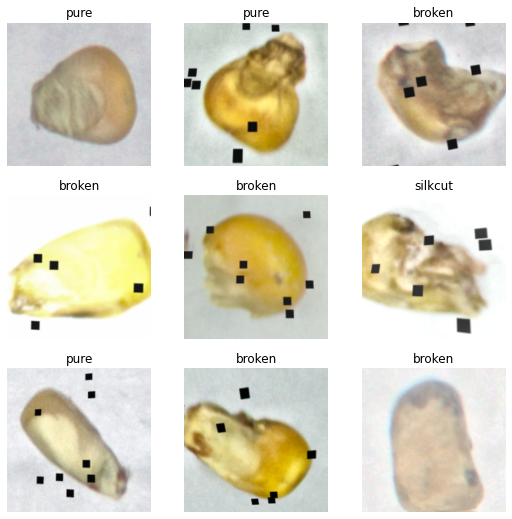

In [11]:
dls = ImageDataLoaders.from_df(train_df,
                               path=path,
                               seed=34,
                               label_col=3,
                               fn_col=2,
                               item_tfms=[Resize(224), AlbumentationsTransform(get_train_aug())],
                               batch_tfms=aug_transforms(size=224)
                              )
dls.show_batch()

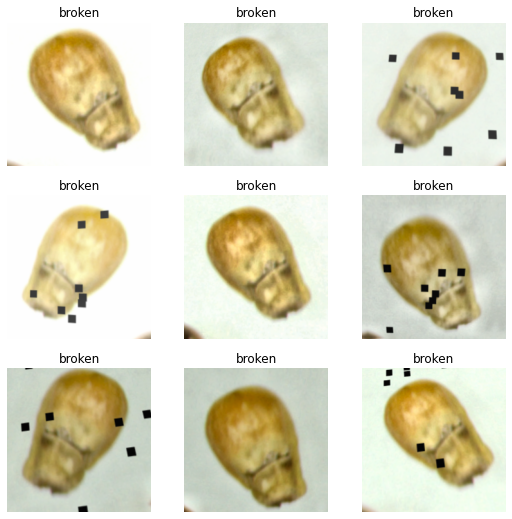

In [12]:
dls.show_batch(unique=True)

## Training model with convnext

In [13]:
learn = vision_learner(dls, 'resnet50d', metrics=[accuracy, Recall(average='weighted'), Precision(average='weighted')])
learn.fine_tune(3)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth" to /root/.cache/torch/hub/checkpoints/resnet50d_ra2-464e36ba.pth


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,time
0,1.449594,1.070627,0.574721,0.574721,0.568928,01:29


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,time
0,1.091640,0.952921,0.592877,0.592877,0.581358,01:34
1,0.975285,0.893702,0.630587,0.630587,0.633474,01:32
2,0.920154,0.878424,0.630936,0.630936,0.631061,01:33


## Submitting Predictions

In [14]:
test_dl = dls.test_dl(test_df)
labels = dls.vocab
mapping = {k: v for k, v in enumerate(labels)}
preds, targets = learn.tta(dl=test_dl)

In [15]:
preds_series = pd.Series(preds.argmax(1))
preds_results = preds_series.map(mapping)
test_df["label"] = preds_results
submission = sub_df["seed_id"]
submission = pd.merge(submission, test_df, on="seed_id")
sub = submission[["seed_id", "label"]]
sub.to_csv("submission.csv", index=False)

## fin.